# Generating the pyTDGL logo

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import tempfile
from typing import List

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
from matplotlib.path import Path
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, ensure_unique

SAVE = False

In [2]:
tempdir = tempfile.TemporaryDirectory()

## Define the letter geometries

In [3]:
# Letters that have loops will require more than one Polygon to define.
loops_uppercase = "ABDOPQR"
loops_lowercase = "abdegopq"

In [4]:
def interp_path(path: Path, points_per_segment: int = 11) -> np.ndarray:
    """Generate polygon coordinates for a given matplotlib Path"""
    # The paths are defined in terms of Bezier curves, so we need to
    # evaluate the curves at many points.
    t = np.linspace(0, 1, points_per_segment)
    segments = [
        bezier(t) for bezier, code in path.iter_bezier() if code != Path.MOVETO
    ]
    points = np.concatenate(segments)
    return ensure_unique(points)

def make_polygons(
    letter: str,
    fontsize: int,
    fontprops: FontProperties,
    resample_points: int = (201, 101),
) -> List[tdgl.Polygon]:
    path = TextPath((0, 0), letter, size=fontsize, prop=fontprops)
    if letter in loops_lowercase + loops_uppercase:
        # If the letter has holes in it, split the overall outline and
        # all holes into separate paths.
        jumps = np.where(path.codes == TextPath.MOVETO)[0][1:]
        vertices = np.split(path.vertices, jumps)
        codes = np.split(path.codes, jumps)
        paths = [Path(v[:-1], c[:-1]) for v, c in zip(vertices, codes)]
    else:
        # If the letter doesn't have holes in it, we only need one path.
        paths = [Path(path.vertices[:-1], path.codes[:-1])]
    polygons = [tdgl.Polygon(points=interp_path(p)) for p in paths]
    # Sort the polygons by area in descending order so that the outline
    # will be first.
    polygons = sorted(polygons, key=lambda p: p.area, reverse=True)
    polygons = (
        [polygons[0].resample(resample_points[0])]
        + [p.resample(resample_points[1]) for p in polygons[1:]]
    )
    # Name the polygons
    for i, p in enumerate(polygons):
        if i == 0:
            p.name = letter
        else:
            p.name = f"{letter}_hole{i}"
    return polygons

## Make a `Device` for each letter

In [5]:
fontsize = 10
fontprops = FontProperties(weight="bold")
xi = 0.4
layer = tdgl.Layer(london_lambda=5, coherence_length=xi, thickness=0.1)

In [6]:
p_outer, p_inner  = make_polygons("p", fontsize, fontprops)
y_outer,  = make_polygons("y", fontsize, fontprops)
film = p_outer.union(y_outer.translate(dx=5.75))

device = tdgl.Device("py", layer=layer, film=film, holes=[p_inner])

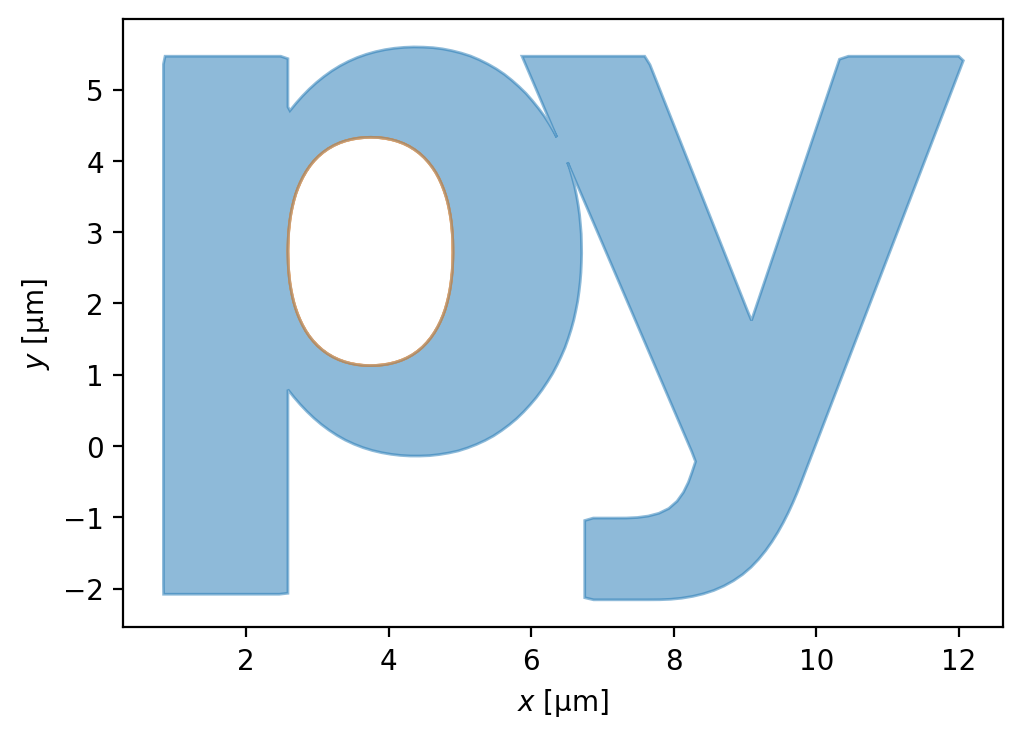

In [7]:
fig, ax = device.draw(legend=False)

## Generate the mesh

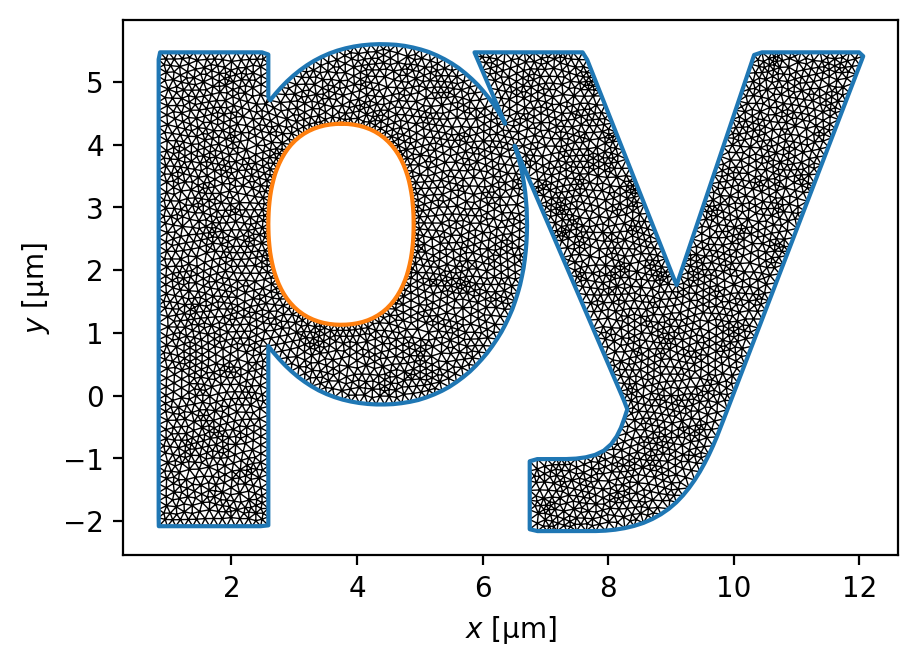

In [8]:
fig, ax = plt.subplots()
device.make_mesh(max_edge_length=xi / 2, smooth=100)
_ = device.plot(ax=ax, mesh=True, legend=False)

## Solve the model

In [9]:
options = tdgl.SolverOptions(
    solve_time=500,
    field_units="mT",
    output_file=os.path.join(tempdir.name, "py.h5"),
)
applied_vector_potential = 1.74

solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Simulating: 100%|█████████████████▉| 500/500 [00:43<00:00, 11.50tau/s ]


## Plot the order parameter

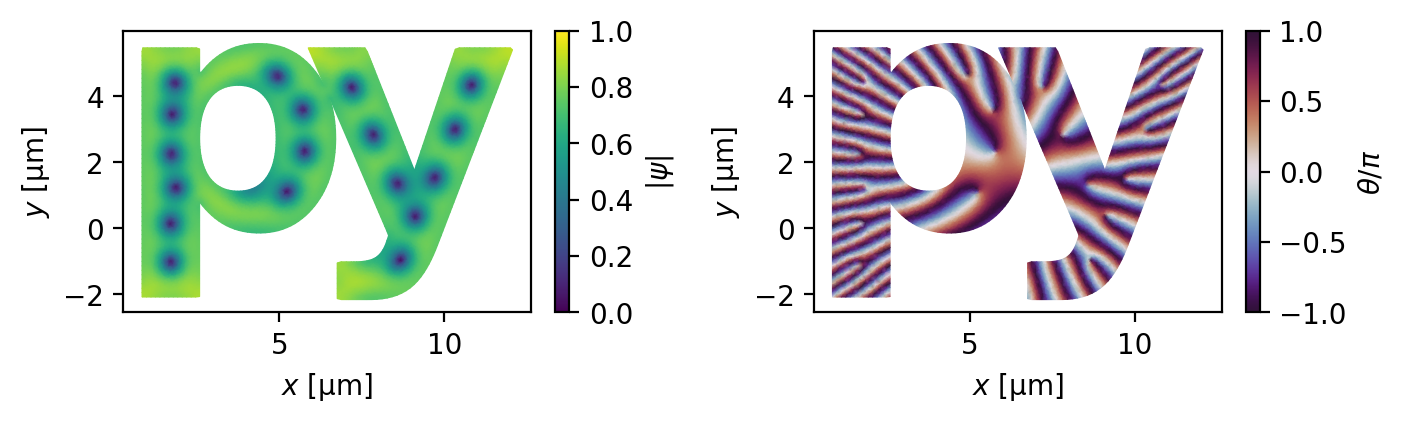

In [10]:
fig, ax = solution.plot_order_parameter(figsize=(7, 2))

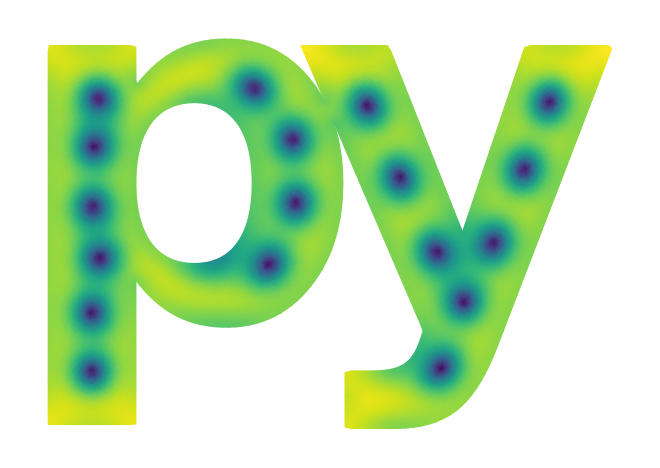

In [11]:
fig, ax = plt.subplots(figsize=(3, 1), facecolor="none")
ax.set_aspect("equal")
ax.axis("off")

device = solution.device
xs, ys = device.points.T
triangles = device.triangles
psi = solution.tdgl_data.psi
ax.tripcolor(xs, ys, triangles, np.abs(psi), cmap="viridis", shading="gouraud")
    
if SAVE:
    fig.set_size_inches(3, 1)
    fig.savefig("../images/logo-transparent-small.png", dpi=300)
    fig.set_size_inches(4, 3)
    fig.savefig("../images/logo-transparent-large.png", dpi=300, bbox_inches="tight")

## Plot the supercurrent density

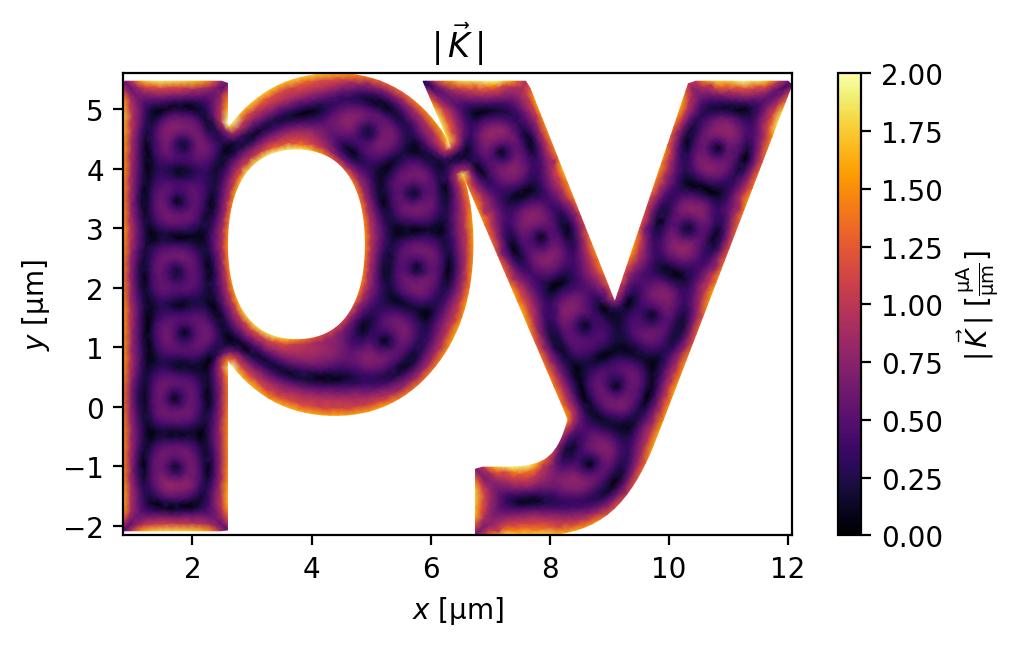

In [12]:
fig, ax = solution.plot_currents(
    dataset="supercurrent",
    figsize=(6, 3),
    vmin=0,
    vmax=2,
    streamplot=False,
)

## Create an animation

In [13]:
from IPython.display import display, HTML
import h5py
from tdgl.visualization.animate import create_animation

In [14]:
def make_video_from_solution(solution, **kwargs):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(h5file, **kwargs)
            video = anim.to_html5_video()
        return HTML(video)

In [15]:
video = make_video_from_solution(
    solution,
    quantities=["order_parameter", "phase"],
    dpi=100,
    fps=50,
    title_off=True,
    axes_off=True,
    max_frame=600,
    max_cols=1,
    figure_kwargs=dict(figsize=(4.5, 6)),
)

In [16]:
display(video)

In [17]:
tempdir.cleanup()

In [18]:
tdgl.version_table()

Software,Version
tdgl,0.0.1
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
BLAS Info,OPENBLAS
